In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2023-09-25 15:46:31.592673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-25 15:46:31.592727: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#spark = SparkSession.builder.appName("DataModeling").getOrCreate()
spark = SparkSession.builder.appName("DataModeling").config("spark.driver.memory", "4g").getOrCreate()

In [4]:
# Read the Parquet file into a DataFrame
df = spark.read.parquet("/user1/data/parquet/*.parquet")

In [5]:
df.show(2, truncate=False)

+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
|square_id|timestamp          |country_code|internet_traffic_activity|hourly_timestamp   |SMS_activity      |call_activity      |weekend_or_weekday|
+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
|1        |2013-10-31 23:00:00|39          |11.028366381681026       |2013-10-31 23:00:00|0.2986512597414538|0.2132127854455914 |weekday           |
|1        |2013-10-31 23:10:00|39          |11.100963451409388       |2013-10-31 23:00:00|0.3983777976024016|0.32241464495433614|weekday           |
+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
only showing top 2 rows



In [6]:
df.printSchema()

root
 |-- square_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = true)



In [11]:
df.count()

7516761

In [12]:
print('Count of distinct rows: {0}'.format(df.distinct().count())) #duplicates

Count of distinct rows: 7516761


In [8]:
df.groupby('country_code').count().sort('count').show(30)

+------------+-------+
|country_code|  count|
+------------+-------+
|          45|      1|
|          40|      1|
|         966|      2|
|         421|      2|
|         353|      3|
|         385|      3|
|          61|      4|
|          31|      4|
|         356|      5|
|          90|      6|
|         386|      7|
|         351|      9|
|          43|     14|
|          32|     15|
|         358|     21|
|           0|     21|
|         213|     23|
|          47|     42|
|          34|     68|
|           1|     91|
|         420|     93|
|          48|     98|
|          49|    151|
|          46|    218|
|           7|    496|
|          86|   1054|
|          44|   1197|
|          33|   1298|
|          41|   1353|
|          39|7510461|
+------------+-------+



In [9]:
# numerical stat
df.describe(['internet_traffic_activity', 'SMS_activity', 'call_activity']).show()

+-------+-------------------------+--------------------+--------------------+
|summary|internet_traffic_activity|        SMS_activity|       call_activity|
+-------+-------------------------+--------------------+--------------------+
|  count|                  7516761|             7516761|             7516761|
|   mean|        81.02824368179743|   7.151377454212734|    8.21545912479918|
| stddev|       143.69671563945369|  14.738696897264143|  16.946580289458204|
|    min|     4.792346910579604E-5|1.235047397115846...|4.662995399058662E-6|
|    max|        7936.265379884158|   1211.443277333027|   532.5074148119132|
+-------+-------------------------+--------------------+--------------------+



In [5]:
from pyspark.sql.functions import col

df = df.withColumn("square_id", col("square_id").cast("integer"))

In [11]:
# correlation
features = ['square_id', 'internet_traffic_activity', 'SMS_activity', 'call_activity']
n = len(features)

corr = []

for i in range(0, n):
    temp = [None]*i
    
    for j in range(i, n):
        temp.append(df.corr(features[i], features[j]))
    corr.append(temp)
    
corr

[[1.0, 0.1415706480958958, 0.12647822181687138, 0.12565426847843997],
 [None, 1.0, 0.8789476193973431, 0.8444776822637831],
 [None, None, 1.0, 0.8929825876389413],
 [None, None, None, 1.0]]

In [6]:
# transform timestamp into categorical values
from pyspark.sql.functions import hour
from pyspark.sql.functions import udf

df = df.withColumn('hour_of_day', hour(df.timestamp))

def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 15:
        return 'lunch'
    elif 15 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'
    
# Apply the UDF to create a new column with categorical values
categorize_hour_udf = udf(categorize_hour)
df = df.withColumn('time_of_day', categorize_hour_udf(df.hour_of_day))

# Show the transformed DataFrame
df.show(3)

+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+-----------+-----------+
|square_id|          timestamp|country_code|internet_traffic_activity|   hourly_timestamp|      SMS_activity|      call_activity|weekend_or_weekday|hour_of_day|time_of_day|
+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+-----------+-----------+
|        1|2013-10-31 23:00:00|          39|       11.028366381681026|2013-10-31 23:00:00|0.2986512597414538| 0.2132127854455914|           weekday|         23|      night|
|        1|2013-10-31 23:10:00|          39|       11.100963451409388|2013-10-31 23:00:00|0.3983777976024016|0.32241464495433614|           weekday|         23|      night|
|        1|2013-10-31 23:20:00|          39|       10.892770602791096|2013-10-31 23:00:00|0.5015934573020482| 0.1887771729145041|      

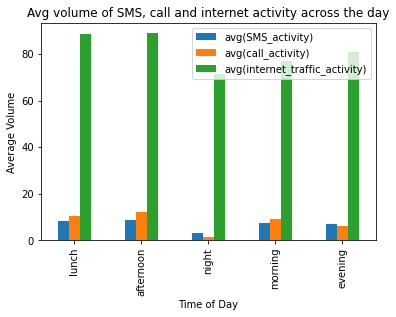

In [13]:
# Group the data by time_of_day and aggregate the average of each activity
activity_by_time_of_day = df.groupBy('time_of_day').agg({'SMS_activity': 'avg', 'call_activity': 'avg', 'internet_traffic_activity': 'avg'})

# Convert the DataFrame to a Pandas DataFrame for plotting
activity_by_time_of_day_pd = activity_by_time_of_day.toPandas()

# Plot the average volume of each activity per time_of_day
activity_by_time_of_day_pd.plot(kind='bar', x='time_of_day', y=['avg(SMS_activity)', 'avg(call_activity)', 'avg(internet_traffic_activity)'])
plt.title('Avg volume of SMS, call and internet activity across the day')
plt.xlabel('Time of Day')
plt.ylabel('Average Volume')
plt.show()

In [7]:
#preparing for modeling (cat values, scaling, splitting)
# handle categorical values

df = df.withColumn('weekend_weekday_encoded',functions.when(df['weekend_or_weekday']=='weekday',0).otherwise(1))
df.show(3)

+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+-----------+-----------+-----------------------+
|square_id|          timestamp|country_code|internet_traffic_activity|   hourly_timestamp|      SMS_activity|      call_activity|weekend_or_weekday|hour_of_day|time_of_day|weekend_weekday_encoded|
+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+-----------+-----------+-----------------------+
|        1|2013-10-31 23:00:00|          39|       11.028366381681026|2013-10-31 23:00:00|0.2986512597414538| 0.2132127854455914|           weekday|         23|      night|                      0|
|        1|2013-10-31 23:10:00|          39|       11.100963451409388|2013-10-31 23:00:00|0.3983777976024016|0.32241464495433614|           weekday|         23|      night|                      0|
|        1|2013

In [8]:
from pyspark.sql.functions import when
df = df.withColumn('time_of_day_encoded', when(df['time_of_day'] == 'morning', 2)
                                          .when(df['time_of_day'] == 'lunch', 3)
                                          .when(df['time_of_day'] == 'afternoon', 4)
                                          .when(df['time_of_day'] == 'evening', 5)
                                          .when(df['time_of_day'] == 'night', 6))

In [9]:
df.printSchema()

root
 |-- square_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- weekend_weekday_encoded: integer (nullable = false)
 |-- time_of_day_encoded: integer (nullable = true)



In [9]:
# selecting features for the model
data = df.select('square_id', 'country_code', 'internet_traffic_activity', 'SMS_activity', 
                 'call_activity', 'time_of_day_encoded', 'weekend_weekday_encoded')

In [10]:
data.printSchema()

root
 |-- square_id: integer (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- time_of_day_encoded: integer (nullable = true)
 |-- weekend_weekday_encoded: integer (nullable = false)



In [46]:
import numpy as np
data_array = np.array(data.collect())

Py4JJavaError: An error occurred while calling o395.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded


In [11]:
#data is too big so we downcast double to float and then take a sample
downcasted_df = data.select([col(c).cast("float") if t == "double" else col(c) for c, t in data.dtypes])
downcasted_df.printSchema()

root
 |-- square_id: integer (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: float (nullable = true)
 |-- SMS_activity: float (nullable = true)
 |-- call_activity: float (nullable = true)
 |-- time_of_day_encoded: integer (nullable = true)
 |-- weekend_weekday_encoded: integer (nullable = false)



In [12]:
sample = downcasted_df.sample(fraction=0.2, seed=42)

In [13]:
# let's try again
import numpy as np
data_array = np.array(sample.collect())

In [17]:
data_array.shape

(1505750, 7)

In [18]:
data_array[0]

array([ 1.        , 39.        ,  8.51417828,  0.21491459,  0.05638824,
        6.        ,  1.        ])

In [19]:
# normalization or scaling

In [20]:
internet = df.select(['internet_traffic_activity']).toPandas()

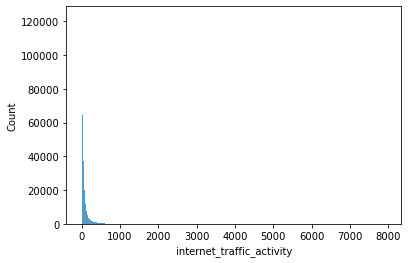

In [22]:
import seaborn as sns
sns.histplot(internet['internet_traffic_activity']);

In [23]:
from pyspark.sql.functions import skewness

skewness_value = df.agg(skewness('SMS_activity')).collect()[0][0]
print(f"The skewness of the 'SMS_activity' column is: {skewness_value}")

The skewness of the 'SMS_activity' column is: 7.866375062955847


In [24]:
skewness_value = df.agg(skewness('call_activity')).collect()[0][0]
print(f"The skewness of the 'call_activity' column is: {skewness_value}")

The skewness of the 'call_activity' column is: 6.846711937178775


In [14]:
def normalize(X):
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)
    X = (X - X.mean(axis=0))/X.std(axis=0)
    return X

In [15]:
X_train = normalize(data_array)
print(X_train)

[[-1.75986712 -0.00657524 -0.50508752 ... -0.48187685  1.58766688
   3.85086641]
 [-1.75986712 -0.00657524 -0.5134828  ... -0.47693077 -1.16699526
  -0.25968182]
 [-1.75986712 -0.00657524 -0.49869492 ... -0.47422186 -1.16699526
  -0.25968182]
 ...
 [ 1.72582484 -0.00657524 -0.34027278 ... -0.44356865  0.89900134
  -0.25968182]
 [ 1.72582484 -0.00657524 -0.43172422 ... -0.45459186  1.58766688
  -0.25968182]
 [ 1.72582484 -0.00657524 -0.45552626 ... -0.46401074  1.58766688
  -0.25968182]]


In [19]:
X_train.shape

(1505750, 7)

In [27]:
# Build the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 32

autoencoder = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    Dense(input_dim, activation='sigmoid')
])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

# Compile and train the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
47055/47055 [==============================] - 164s 3ms/step - loss: 0.6569
Epoch 2/10
47055/47055 [==============================] - 165s 4ms/step - loss: 0.6538
Epoch 3/10
47055/47055 [==============================] - 135s 3ms/step - loss: 0.6537
Epoch 4/10
47055/47055 [==============================] - 131s 3ms/step - loss: 0.6537
Epoch 5/10
47055/47055 [==============================] - 163s 3ms/step - loss: 0.6537
Epoch 6/10
47055/47055 [==============================] - 167s 4ms/step - loss: 0.6537
Epoch 7/10
47055/47055 [==============================] - 170s 4ms/step - loss: 0.6537
Epoch 8/10
47055/47055 [==============================] - 142s 3ms/step - loss: 0.6536
Epoch 9/10
47055/47055 [==============================] - 427s 9ms/step - loss: 0.6536
Epoch 10/10
47055/47055 [==============================] - 622s 13ms/step - loss: 0.6536


In [28]:
# saving this model
autoencoder.save('model_1.h5')

In [22]:
# load the model

autoencoder = load_model('model_1.h5')

2023-09-24 19:47:26.700522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-24 19:47:26.701116: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-24 19:47:26.702389: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (muhammad-VM): /proc/driver/nvidia/version does not exist
2023-09-24 19:47:26.710835: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# Detect anomalies using the trained autoencoder
reconstructed_data = autoencoder.predict(X_train)

In [24]:
mse = tf.keras.losses.mean_squared_error(X_train, reconstructed_data)
print(mse)

tf.Tensor([1.7540516  0.74861664 0.74164706 ... 0.14400218 0.21132672 0.22080505], shape=(1505750,), dtype=float32)


2023-09-24 19:48:46.315114: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84322000 exceeds 10% of free system memory.


Measuring the accuracy of an autoencoder model for anomaly detection is a bit different from traditional classification models because autoencoders are not directly trained for accuracy. Instead, they are trained to minimize reconstruction error. The accuracy of an autoencoder model is typically evaluated using metrics related to reconstruction error and anomaly detection performance.<br>
The most straightforward metric is the Mean Squared Error between the input data and the reconstructed data. Lower MSE values indicate better reconstruction performance

In [92]:
accuracy = np.mean(np.square(X_train, reconstructed_data))
accuracy

0.99999875

In [25]:
# anomaly_threshold = mse.mean() + mse.std() * 2  # Adjust the threshold as per your requirements
anomaly_threshold = tf.reduce_mean(mse) + tf.math.reduce_std(mse) * 2

anomalies = X_train[mse > anomaly_threshold]

In [27]:
anomalies.shape

(1028, 7)

To detect anomalies using an autoencoder model, you can compare the reconstructed data with the original data. Anomalies are typically identified as instances where the reconstructed data deviates significantly from the original data.

In [34]:
# find threshold
errors = tf.keras.losses.msle(reconstructed_data, X_train)
threshold = np.mean(errors.numpy()) + np.std(errors.numpy())

2023-09-24 19:58:13.746428: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84322000 exceeds 10% of free system memory.
2023-09-24 19:58:13.887942: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84322000 exceeds 10% of free system memory.
2023-09-24 19:58:13.939873: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84322000 exceeds 10% of free system memory.
2023-09-24 19:58:14.033737: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84322000 exceeds 10% of free system memory.


In [98]:
# ----------- #
# Model according to O reilly 

In [20]:
input_dim = X_train.shape[1]

# Encoder
encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu')
])

# Decoder
decoder = Sequential([
    Input(shape=(32,)),  # Match the output shape of the encoder
    Dense(64, activation='relu'),
    Dense(input_dim, activation='linear')
])

# Autoencoder (combines the encoder and decoder)
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])

2023-09-25 13:35:16.846862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-25 13:35:16.846910: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-25 13:35:16.846948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (muhammad-VM): /proc/driver/nvidia/version does not exist
2023-09-25 13:35:16.850619: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, callbacks=[early_stopping])

Epoch 1/10
23528/23528 [==============================] - 125s 5ms/step - loss: 0.0285 - mae: 0.0200 - accuracy: 0.9856
Epoch 2/10
23528/23528 [==============================] - 117s 5ms/step - loss: 0.0179 - mae: 0.0158 - accuracy: 0.9887
Epoch 3/10
23528/23528 [==============================] - 128s 5ms/step - loss: 0.0140 - mae: 0.0116 - accuracy: 0.9919
Epoch 4/10
23528/23528 [==============================] - 129s 5ms/step - loss: 0.0101 - mae: 0.0127 - accuracy: 0.9914
Epoch 5/10
23528/23528 [==============================] - 132s 6ms/step - loss: 0.0201 - mae: 0.0109 - accuracy: 0.9923
Epoch 6/10
23528/23528 [==============================] - 128s 5ms/step - loss: 0.0168 - mae: 0.0126 - accuracy: 0.9915
Epoch 7/10
23528/23528 [==============================] - 130s 6ms/step - loss: 0.0172 - mae: 0.0111 - accuracy: 0.9930
Epoch 8/10
23528/23528 [==============================] - 126s 5ms/step - loss: 0.0150 - mae: 0.0118 - accuracy: 0.9916


In [23]:
autoencoder.save('model.h5')

In [16]:
autoencoder = load_model('model.h5')

2023-09-25 15:49:34.670295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-25 15:49:34.670367: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-25 15:49:34.670403: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (muhammad-VM): /proc/driver/nvidia/version does not exist
2023-09-25 15:49:34.671646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 23528}

In [31]:
history.history.keys()

dict_keys(['loss', 'mae', 'accuracy'])

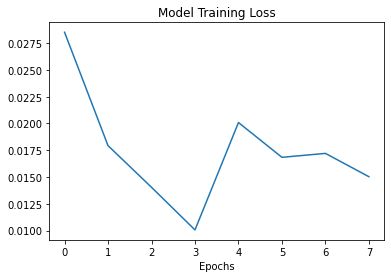

In [40]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Model Training Loss')
plt.show()

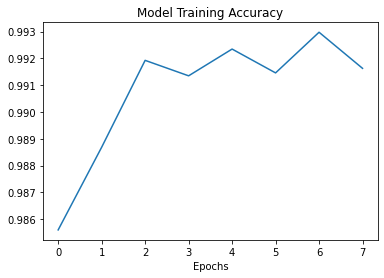

In [39]:
plt.plot(training_accuracy, label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Model Training Accuracy')
plt.show()

In [41]:
# let's evaluate the model
score = autoencoder.evaluate(X_train, X_train, verbose=1)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

47055/47055 [==============================] - 170s 4ms/step - loss: 0.0023 - mae: 0.0035 - accuracy: 0.9981
Test loss:  0.0022885350044816732
Test accuracy:  0.003480855841189623


In [17]:
reconstructions = autoencoder.predict(X_train)

In [18]:
# Calculate the reconstruction errors (MSE)
mse = np.mean(np.square(X_train - reconstructions), axis=1)

# Define a threshold for anomaly detection (e.g., based on a quantile of the MSE values)
threshold = 2.0  # Adjust this threshold as needed

# Identify anomalies based on the threshold
anomalies = np.where(mse > threshold)[0]
anomalies.shape

(96,)

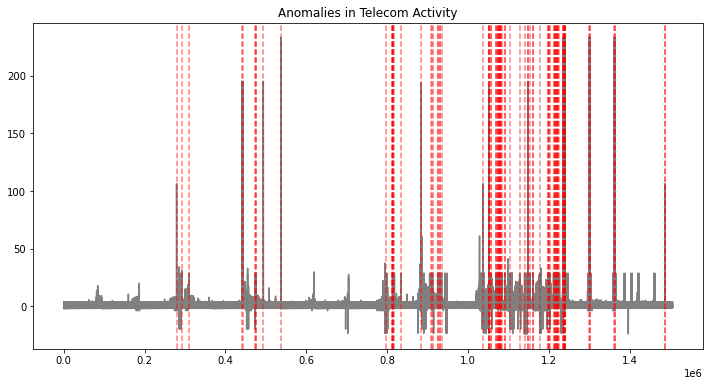

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(X_train)), X_train, color='gray')

# Plot anomalies as vertical lines
for anomaly_idx in anomalies:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--', alpha=0.5)

plt.title('Anomalies in Telecom Activity')
plt.show()